<center style="font-size: 16px; font-weight: normal">
  `21 Microservices Architecture Patterns Study</center>

<center><h1>Chapter 7. Aggregates and Consistency Boundaries</h1></center>

<center>
  Joseph Kim &lt;cloudeyes@gmail.com&gt;<br/>
  Jan 28. 2021<br/>
</center>

<center>
  <img src="https://images-na.ssl-images-amazon.com/images/I/51-q9CWNBHL._SX379_BO1,204,203,200_.jpg" style="width: 200px">
</center>

<center>
  <a href="https://github.com/cloudeyes/2021-msa-study/blob/main/07-aggregates-boundaries/07-aggregates-boundaries.ipynb">Download Jupyter Notebook</a>
</center>

# 07. Aggregates and Consistency Boundaries

## Introduction

### 지난 내용 복습

### Sanity Checks for the project

#### Project structure

In [4]:
!tree app -I '__pycache__' --sort=version

app
├── __init__.py
├── __main__.py
├── adapters
│   ├── __init__.py
│   ├── orm.py
│   └── repository.py
├── apps
│   ├── __init__.py
│   ├── fastapi.py
│   └── flask.py
├── config.py
├── domain
│   ├── __init__.py
│   └── models.py
├── requirements.txt
├── routes
│   ├── __init__.py
│   └── flask.py
└── services
    ├── __init__.py
    ├── batch.py
    └── uow.py

5 directories, 17 files


In [21]:
!mypy -p app --strict

Success: no issues found in 16 source files


In [22]:
!pylint app


--------------------------------------------------------------------
Your code has been rated at 10.00/10 (previous run: 10.00/10, +0.00)



In [23]:
!pytest

============================= test session starts ==============================
platform linux -- Python 3.9.1, pytest-6.1.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/ykkim/notebooks/2021-msa-study/07-aggregates-boundaries
plugins: flask-1.1.0, anyio-2.0.2
collected 34 items                                                             

tests/e2e/test_api.py .                                                  [  2%]
tests/integration/test_orm.py ......                                     [ 20%]
tests/integration/test_repository.py ..                                  [ 26%]
tests/integration/test_uow.py ......                                     [ 44%]
tests/unit/test_allocate.py ....                                         [ 55%]
tests/unit/test_batch.py .........                                       [ 82%]
tests/unit/test_services.py ......                                       [100%]

============================== 34 passed in 0.96s ==============================


### 테스트 피라미드는?

In [24]:
from tests.utils import get_test_counts, show_test_pyramid
test_counts = get_test_counts(); test_counts

{'unit': 20, 'integration': 14, 'e2e': 1}

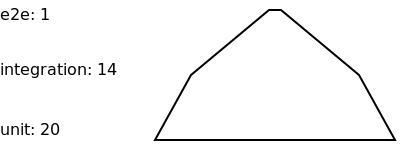

In [25]:
show_test_pyramid(test_counts)

## Why Not Just Run Everything in a Spreadsheet?

## Invariants, Constraints, and Consistency

### Invariants, Concurrency, and Locks

## What Is an Aggregate?

## Choosing an Aggregate

## One Aggregate = One Repository

## What About Performance?

## Optimistic Concurrency with Version Numbers

### Implementation Options for Version Numbers

## Testing for Our Data Integrity Rules

## Wrap-Up

## Part I Recap



## Part II Preview - Event-Driven Architecture

### 08. Events and the Message Bus

### 09. Going to Town on the Message Bus

### 10. Commands and Command Handler

### 11. Event-Driven Architecture: Using Events to Integrate Microservices

### 12. Command-Query Responsibility Segregation (CQRS)

### 13. Dependency Injection (and Bootstrapping)

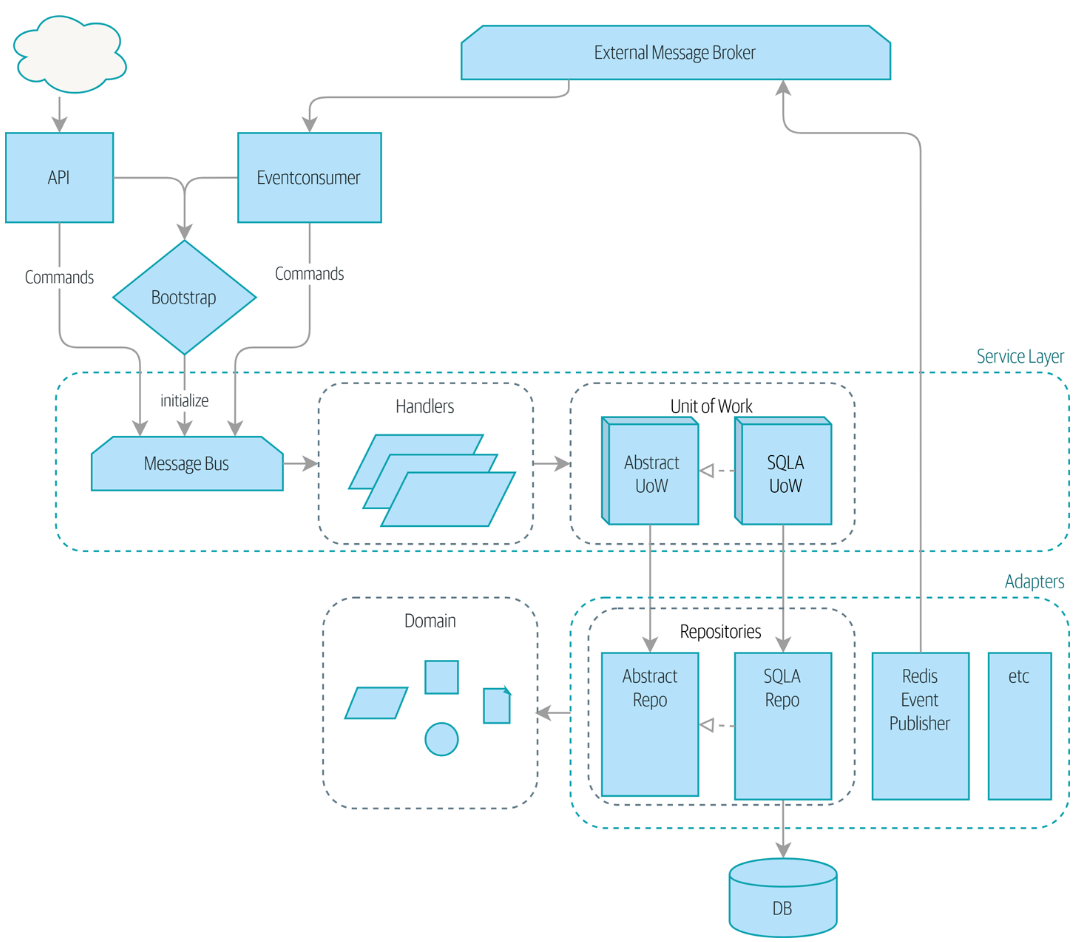